In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

## Importing file

In [4]:
os.environ['KAGGLE_USERNAME'] = "X" 
os.environ['KAGGLE_KEY'] = "X"
!kaggle competitions download -c ieee-fraud-detection 

 78% 41.0M/52.5M [00:00<00:00, 59.9MB/s]
100% 52.5M/52.5M [00:00<00:00, 67.4MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 202MB/s]
 87% 41.0M/47.3M [00:00<00:00, 39.7MB/s]
100% 47.3M/47.3M [00:00<00:00, 80.7MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 203MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 161MB/s]


In [0]:
from zipfile import ZipFile

zf = ZipFile('train_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('train_identity.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_identity.csv.zip', 'r')
zf.extractall()
zf.close()

>> # Data Processing For Virtualization

In [0]:
ttc = pd.read_csv('train_transaction.csv', low_memory=False)
tic = pd.read_csv('train_identity.csv', low_memory=False)
tstc = pd.read_csv('test_transaction.csv', low_memory=False)
tstic = pd.read_csv('test_identity.csv', low_memory=False)

In [0]:
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
ttc = reduce_mem_usage(ttc)
tic = reduce_mem_usage(tic)
tstc = reduce_mem_usage(tstc)
tstic = reduce_mem_usage(tstic)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [0]:
train = pd.merge(ttc, tic, on = 'TransactionID', how = 'left')
test = pd.merge(tstc, tstic, on = 'TransactionID', how = 'left')

In [0]:
del ttc, tic, tstc, tstic

In [0]:
miss_data = pd.isnull(train).sum().sort_values(ascending=False)
miss_per = (miss_data/len(train))*100
missing_data = pd.concat(objs = [miss_data, miss_per], keys = ['Columns','Missing values percentage'], axis = 1)

In [0]:
def delnullcol(dt):
    nullcol = [col for col in dt.columns if dt[col].isnull().sum()/dt.shape[0] >= 0.9]
    return nullcol

In [0]:
rep_vals = [col for col in train.columns if train[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
cols=[]
for col in rep_vals:
    cols.append(train[col].value_counts(dropna = False).values[0])

In [0]:
def repcols(dt):
    rep_vals = [col for col in dt.columns if dt[col].value_counts(dropna = False, normalize = True).values[0] >= 0.9]
    return rep_vals

In [0]:
def useless_cols(dt, exep):
    null_cols = delnullcol(dt)
    print("More than 90% null: " + str(len(null_cols)))
    too_many_repeated = repcols(dt)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(null_cols + too_many_repeated))
    cols_to_drop.remove(exep)
    return cols_to_drop

In [16]:
cols_to_drop = useless_cols(train, 'isFraud')

More than 90% null: 12
More than 90% repeated value: 67


>> ## Visualisation

In [0]:
sns.set(style = "whitegrid")

## Plot for missing values in the columns in the training dataset 

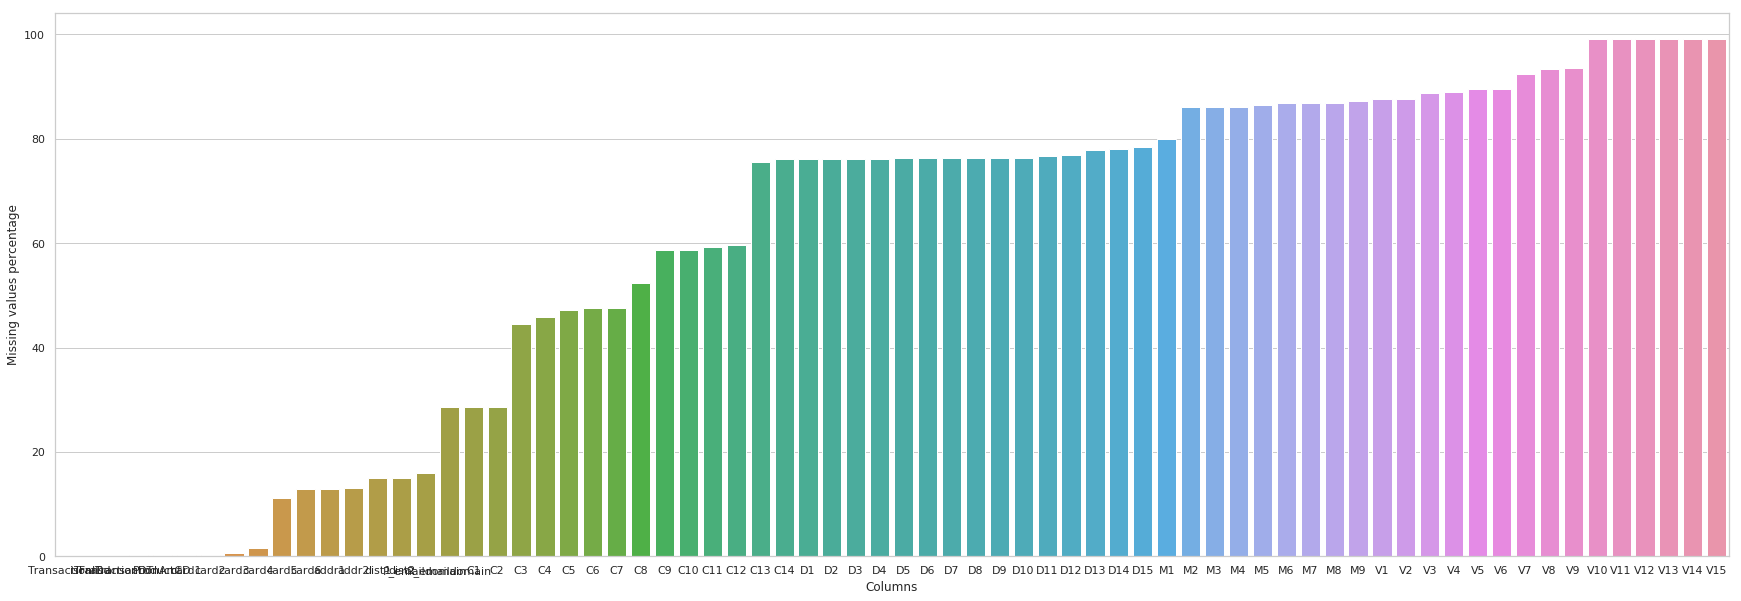

In [19]:
plt.figure(figsize=(30,10))
p = sns.barplot(x = 'Columns', y = 'Missing values percentage', data = missing_data)
p.set_xticklabels(list(train.columns))
p

>> ## Data Processing for ML

In [0]:
train = train.drop(cols_to_drop, axis=1)

In [0]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [22]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,4.242188,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,3.400391,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,4.093750,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,3.931641,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,3.931641,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,542.0,144.0,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
y_train = train['isFraud']
train = pd.get_dummies(train)
X_train = train.drop('isFraud', axis=1)
X_train = X_train.fillna(0)

In [0]:
del train

In [0]:
q = 0
scaler = MinMaxScaler()
for col in X_train.columns:
    a = np.array(X_train[col])
    a = a.reshape(-1,1)
    X_train[col] = scaler.fit_transform(a)
    if q >= 100:
        break
    else:
        q+=1
        continue

In [0]:
del a

>> ## Running ML Models

##Logistic Regression

In [0]:
lr = LogisticRegression(solver="liblinear", random_state=42)
lr.fit(X_train, y_train[:np.shape(X_train)[0]])

In [0]:
score = cross_val_score(lr, x_train, y_train[:np.shape(x_train)[0]], cv=3, verbose=3)
score.mean()

[CV]  ................................................................
[CV] .................................... , score=0.979, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.979, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.980, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


0.9797470918387775

##Random Forest Classifier

In [0]:
rf = RandomForestClassifier(n_estimators=1000, bootstrap=False, max_features=0.33, n_jobs=4)
rf.fit(X_train, y_train[:np.shape(X_train)[0]])

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.33, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
score = cross_val_score(lr, X_train, y_train[:np.shape(X_train)[0]], cv=3, verbose=3)
score.mean()

[CV]  ................................................................
[CV] .................................... , score=0.979, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.979, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.980, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


0.9797470918387775